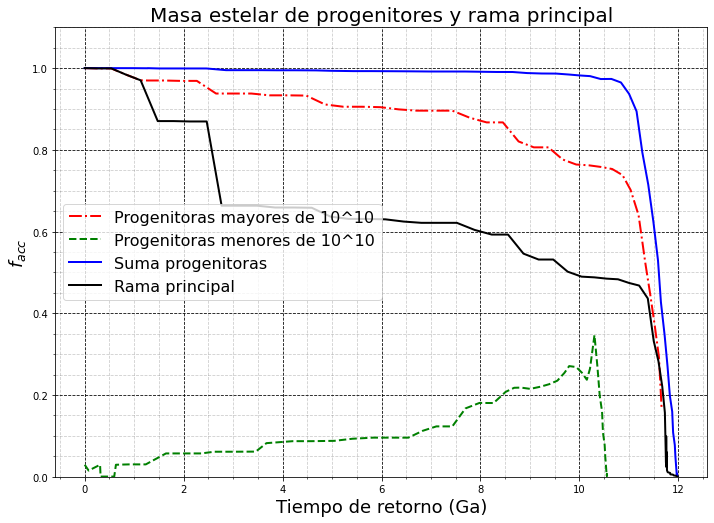

In [21]:
from os import getcwd

from bisect import bisect_left, bisect_right
import matplotlib.pyplot as plt
from numpy import arange, log10, nan
import pandas as pd

fig, ax = plt.subplots(figsize=(11.69, 8.27))

#fig.subplots_adjust(bottom=0.5)
main_df = pd.read_csv(getcwd() + '/datos/galaxias_13.csv')

# Obtiene el valor maximo y minimo de massWeightedAge
minWeightAge = min(main_df['massWeightedAge'])
maxWeightAge = max(main_df['massWeightedAge'])

# Divide en porciones
arrayWeightAge = arange(minWeightAge, maxWeightAge, 0.05)
longArrayWeightAge = arange(minWeightAge, maxWeightAge, 0.01)

# Obtiene los valores de masa del ultimo instante (step)
dfWeightAge = main_df[main_df['massWeightedAge'] > arrayWeightAge[-1]]
# Obtiene la fila de la galaxia con mas masa del ultimo instante
lastGalaxyRow = main_df[main_df['stellarMass'].isin([max(dfWeightAge['stellarMass'])])]

# Si tenemos dos valores (posiblemente por un error de redondeo obtenemos el más antiguo)
if lastGalaxyRow['treeId'].size != 1:
    lastGalaxyRow = lastGalaxyRow[lastGalaxyRow['massWeightedAge'].isin([max(lastGalaxyRow['massWeightedAge'])])]
    
#
# Obtenemos los valores del arbol
#
descendantId = lastGalaxyRow['galaxyID']
flag = True

descendant_ids_dict = {}
main_ids = []
main_snapnums = []
# Primera iteracion
temp_df = main_df[main_df['descendantId'].isin([descendantId])]
main_ids.append(int(descendantId))
descendant_ids_dict[int(descendantId)] = list(range(int(descendantId),
                                              int(temp_df['lastProgenitorId']), 1))
while flag:  
    nextGalaxyID = int(temp_df['galaxyID'])
    main_ids.append(nextGalaxyID)
    temp_df = main_df[main_df['descendantId'].isin([nextGalaxyID])]
    # Para el bucle si ya no hay datos
    if temp_df.empty:
        flag = False
        break
    descendant_ids_dict[nextGalaxyID] = list(range(int(nextGalaxyID), 
                                             int(temp_df['lastProgenitorId']), 1))

#
# Obtenemos la masa y edad de la principal
# 
main_df = main_df[main_df['galaxyID'].isin(main_ids)]
total_df = pd.read_csv(getcwd() + '/datos_completos/galaxias_13.csv')

#
# Calculo de la rama principal
#

# Define las listas para el branch principal
main_stellarMass = []
main_weightedAge = []

# Metodo snapnum a snapnum
for snapnum_ in list(set(main_df['snapnum'].tolist())):
    # Corta los datos en mass = 10
    temp_main_df = main_df[main_df['snapnum'].isin([snapnum_])]
    main_stellarMass.append(float(temp_main_df['stellarMass']))
    main_weightedAge.append(float(temp_main_df['massWeightedAge']))

# Obtiene el valor final de la masa
last_stellarMass = main_stellarMass[:1][0]

# Invierte las edades
main_weightedAge = [abs(i - max(main_weightedAge)) for i in main_weightedAge]

# Normaliza las masas
final_stellarMass = max(main_stellarMass)  # Lo guarda en una variable para después
main_stellarMass = [i/final_stellarMass for i in main_stellarMass]

#
# Calculo de los progenitores
#

# Define las listas para los progenitores
total_stellarMass_more_10 = []
total_stellarMass_less_10 = []
total_weightedAge_more_10 = []
total_weightedAge_less_10 = []
total_stellarMass = []
total_weightedAge = []

# Metodo snapnum a snapnum
for snapnum_ in list(set(total_df['snapnum'].tolist())):
    # Corta los datos en mass = 10
    temp_total_df = total_df[total_df['snapnum'].isin([snapnum_])]
    temp_total_stellarMass_more_10 = temp_total_df[temp_total_df['stellarMass'] >= 1.0]
    if not temp_total_stellarMass_more_10.empty:
        total_stellarMass_more_10_value = float(temp_total_stellarMass_more_10['stellarMass'].sum())
        total_stellarMass_more_10.append(total_stellarMass_more_10_value)
        total_weightedAge_more_10_value = float(temp_total_stellarMass_more_10['massWeightedAge'].mean())
        total_weightedAge_more_10.append(total_weightedAge_more_10_value)

    temp_total_stellarMass_less_10 = temp_total_df[temp_total_df['stellarMass'] < 1.0]
    if not temp_total_stellarMass_less_10.empty:
        total_stellarMass_less_10_value = float(temp_total_stellarMass_less_10['stellarMass'].sum())
        total_stellarMass_less_10.append(total_stellarMass_less_10_value)
        total_weightedAge_less_10_value = float(temp_total_stellarMass_less_10['massWeightedAge'].mean())
        total_weightedAge_less_10.append(total_weightedAge_less_10_value)

    if not temp_total_stellarMass_more_10.empty and not temp_total_stellarMass_less_10.empty:
        total_stellarMass.append(total_stellarMass_more_10_value + total_stellarMass_less_10_value)
        total_weightedAge.append((total_weightedAge_more_10_value + total_weightedAge_less_10_value)/2)
    elif not temp_total_stellarMass_more_10.empty:
        total_stellarMass.append(total_stellarMass_more_10_value)
        total_weightedAge.append(total_weightedAge_more_10_value)
    elif not temp_total_stellarMass_less_10.empty:
        total_stellarMass.append(total_stellarMass_less_10_value)
        total_weightedAge.append(total_weightedAge_less_10_value)
    else:
        raise Exception


# Invierte las edades
total_weightedAge_more_10 = [abs(i - max(total_weightedAge_more_10)) for i in total_weightedAge_more_10]
total_weightedAge_less_10 = [abs(i - max(total_weightedAge_less_10)) for i in total_weightedAge_less_10]
total_weightedAge = [abs(i - max(total_weightedAge)) for i in total_weightedAge]

# Ordena las listas de todos los progenitores
total_lists = zip(*sorted(zip(total_weightedAge_more_10, total_stellarMass_more_10)))
total_weightedAge_more_10, total_stellarMass_more_10 = (list(t) for t in total_lists)
total_lists = zip(*sorted(zip(total_weightedAge_less_10, total_stellarMass_less_10)))
total_weightedAge_less_10, total_stellarMass_less_10 = (list(t) for t in total_lists)
total_lists = zip(*sorted(zip(total_weightedAge, total_stellarMass)))
total_weightedAge, total_stellarMass = (list(t) for t in total_lists)

# Normaliza los resultados
total_stellarMass_more_10 = [i/final_stellarMass for i in total_stellarMass_more_10]
total_stellarMass_less_10 = [i/final_stellarMass for i in total_stellarMass_less_10]
total_stellarMass = [i/final_stellarMass for i in total_stellarMass]

# Plotea todos los progenitores
ax.plot(total_weightedAge_more_10, total_stellarMass_more_10, linestyle='dashdot',color='red', 
        linewidth=2, label='Progenitoras mayores de 10^10')
ax.plot(total_weightedAge_less_10, total_stellarMass_less_10, linestyle='dashed',color='green',
        linewidth=2, label='Progenitoras menores de 10^10')

# Plotea la suma de los progenitores
ax.plot(total_weightedAge, total_stellarMass, linestyle='solid',color='blue', 
        linewidth=2, label='Suma progenitoras')

# Ordena las listas de la rama principal
main_lists = zip(*sorted(zip(main_weightedAge, main_stellarMass)))
main_weightedAge, main_stellarMass = (list(t) for t in main_lists)

# Plotea el branch principal
ax.plot(main_weightedAge, main_stellarMass, linestyle='-',color='black', linewidth=2,
        label='Rama principal')

# Pone el titulo de la grafica
ax.set_title('Masa estelar de progenitores y rama principal', fontsize=20)

# Pone nombre a los ejes
ax.set_xlabel('Tiempo de retorno (Ga)', fontsize=18)
# ax.set_ylabel('M')
ax.set_ylabel(r'$f_{acc}$', fontsize=18)


# ax.set_yticks(arange(0, 20))
ax.set_ylim([0.0, 1.1])

# Crea el grid
plt.grid(b=True, which='major', color='black', linestyle='dashed')
plt.grid(b=True, which='minor', color='black', linestyle='dashed', alpha=0.2)
plt.minorticks_on()

# Activa la leyenda
plt.legend(fontsize=16)

# Guarda la figura
plt.savefig('figura4.jpg')